In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

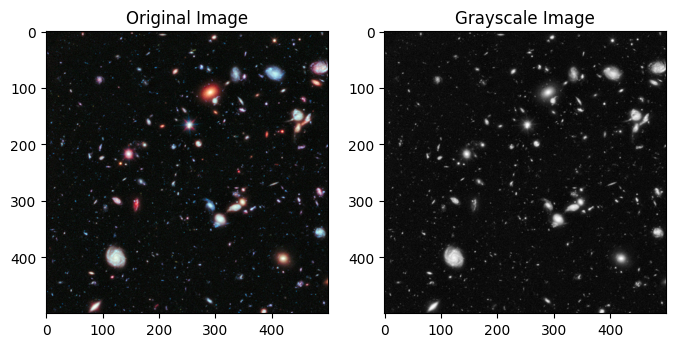

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, color, exposure

# Load sample image
image = data.hubble_deep_field()[0:500, 0:500]
image_gray = color.rgb2gray(image)

plt.figure(figsize=(8, 4))
plt.subplot(121), plt.imshow(image), plt.title('Original Image')
plt.subplot(122), plt.imshow(image_gray, cmap='gray'), plt.title('Grayscale Image')
plt.show()

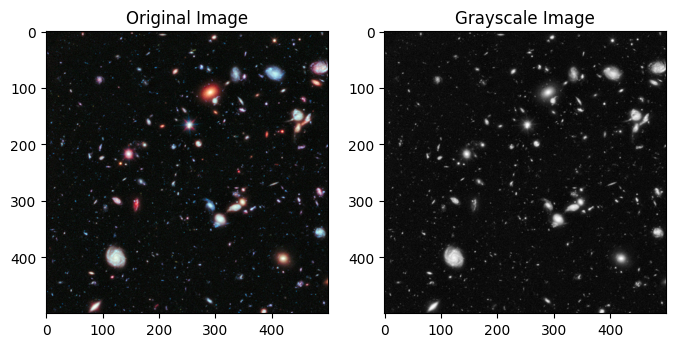

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_dog, hog  # Corrected imports
from skimage import data, color, exposure
from skimage.color import rgb2gray

# Load sample image
image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

plt.figure(figsize=(8, 4))
plt.subplot(121), plt.imshow(image), plt.title('Original Image')
plt.subplot(122), plt.imshow(image_gray, cmap='gray'), plt.title('Grayscale Image')
plt.show()

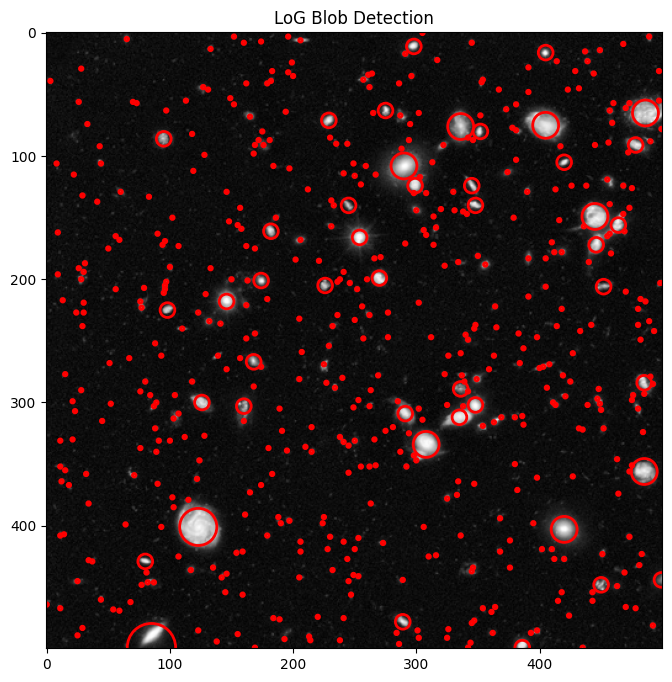

In [5]:
def log_blob_detection(image, min_sigma=1, max_sigma=30, num_sigma=10, threshold=0.1):
    # Detect blobs using Laplacian of Gaussian
    blobs_log = blob_log(image, min_sigma=min_sigma, max_sigma=max_sigma, 
                        num_sigma=num_sigma, threshold=threshold)
    
    # Convert radii to diameters
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    
    for blob in blobs_log:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax.add_patch(c)
    
    ax.set_title('LoG Blob Detection')
    plt.show()
    
    return blobs_log

# Run LoG detection
blobs_log = log_blob_detection(image_gray)

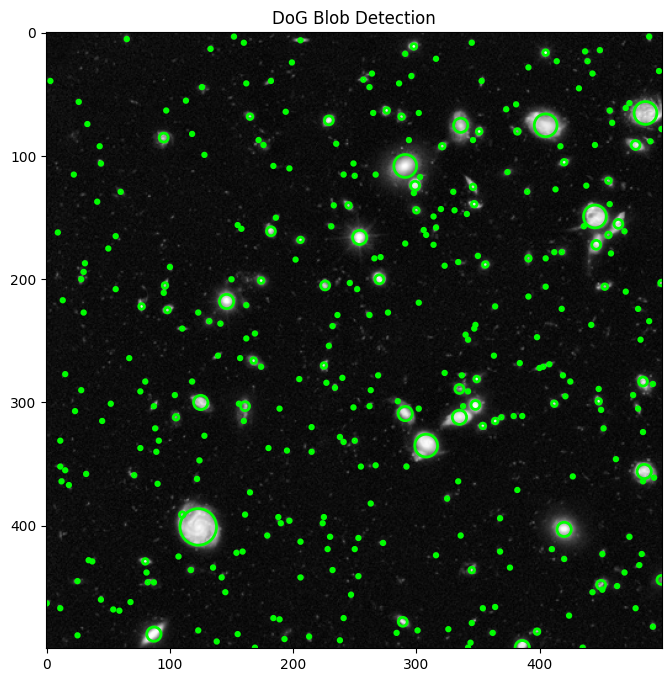

In [6]:
def dog_blob_detection(image, min_sigma=1, max_sigma=30, threshold=0.1):
    # Detect blobs using Difference of Gaussian
    blobs_dog = blob_dog(image, min_sigma=min_sigma, 
                        max_sigma=max_sigma, threshold=threshold)
    
    # Convert radii to diameters
    blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    
    for blob in blobs_dog:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
        ax.add_patch(c)
    
    ax.set_title('DoG Blob Detection')
    plt.show()
    
    return blobs_dog

# Run DoG detection
blobs_dog = dog_blob_detection(image_gray)

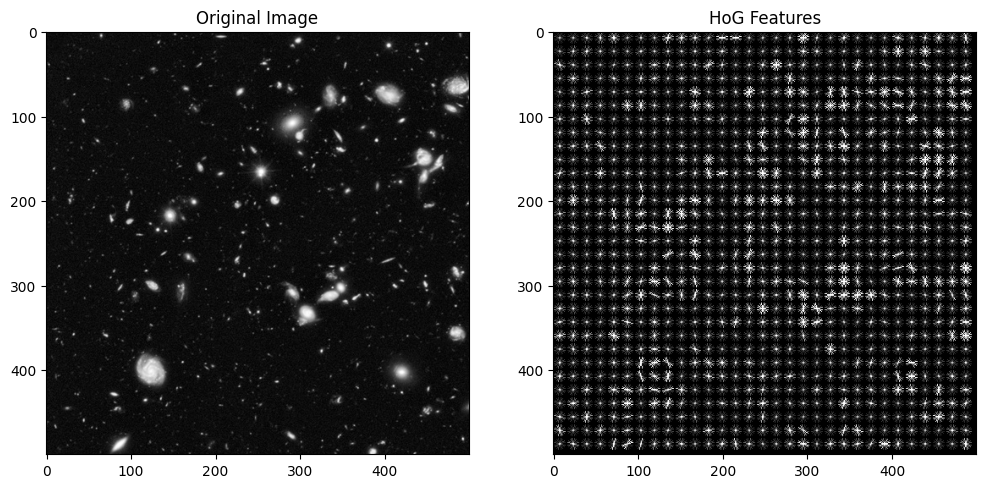

In [7]:
def hog_feature_detection(image, orientations=8, pixels_per_cell=(16, 16)):
    # Compute HOG features
    fd, hog_image = hog(image, orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=(1, 1),
                       visualize=True)
    
    # Rescale HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original Image')
    
    ax2.imshow(hog_image_rescaled, cmap='gray')
    ax2.set_title('HoG Features')
    
    plt.show()
    
    return hog_image

# Run HOG detection
hog_image = hog_feature_detection(image_gray)

NameError: name 'hog_image_rescaled' is not defined

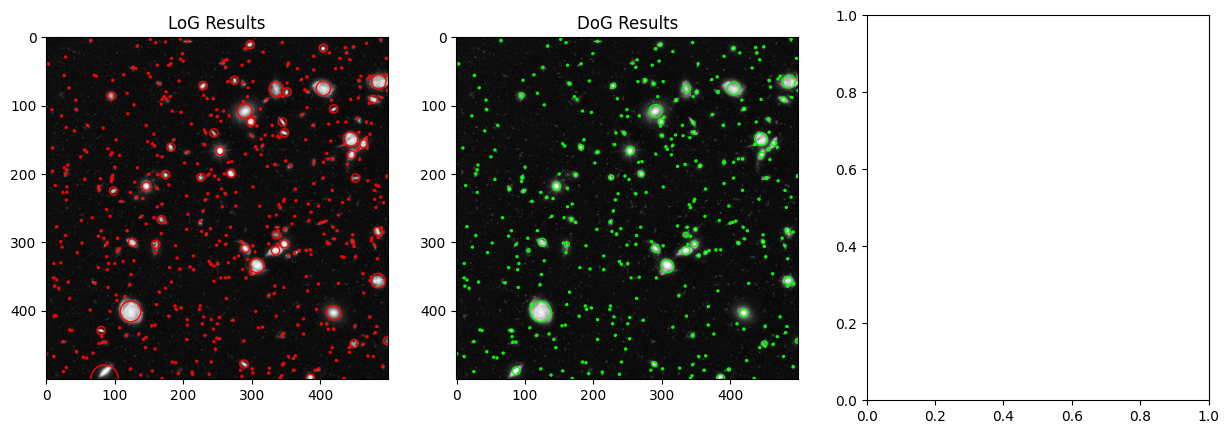

In [8]:
# Compare results side by side
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_gray, cmap='gray')
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=1, fill=False)
    plt.gca().add_patch(c)
plt.title('LoG Results')

plt.subplot(132)
plt.imshow(image_gray, cmap='gray')
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='lime', linewidth=1, fill=False)
    plt.gca().add_patch(c)
plt.title('DoG Results')

plt.subplot(133)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('HOG Results')

plt.tight_layout()
plt.show()

Image Classification using ResNet on CIFAR-100

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                        shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torchvision.models import resnet18, resnet34

# Step 1: Check GPU availability and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 2: Load and preprocess CIFAR-100 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                        shuffle=False, num_workers=2)

# Step 3: Define model modification function for CIFAR-100
def modify_resnet(model):
    # Adjust for CIFAR-100's 32x32 input size
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove initial maxpool
    model.fc = nn.Linear(model.fc.in_features, 100)  # 100 classes for CIFAR-100
    return model

# Step 4: Initialize models
resnet18_model = modify_resnet(resnet18(pretrained=True)).to(device)
resnet34_model = modify_resnet(resnet34(pretrained=True)).to(device)

# # Verify model architectures
# print("ResNet-18 architecture:")
# summary(resnet18_model, (3, 32, 32))

# print("\nResNet-34 architecture:")
# summary(resnet34_model, (3, 32, 32))

# Step 5: Define training and evaluation functions
def train_model(model, name, trainloader, testloader, epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'times': []
    }
    
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        scheduler.step()
        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct / total
        test_acc = evaluate_model(model, testloader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['times'].append(time.time() - epoch_start)
        
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Loss: {train_loss:.4f} | '
              f'Train Acc: {train_acc:.2f}% | '
              f'Test Acc: {test_acc:.2f}% | '
              f'Time: {history["times"][-1]:.2f}s')
    
    history['total_time'] = time.time() - start_time
    print(f'Finished training {name} in {history["total_time"]:.2f} seconds')
    return history

def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

# Step 6: Train both models
epochs = 25

# Train ResNet-18
resnet18_history = train_model(resnet18_model, "ResNet-18", trainloader, testloader, epochs)

# Train ResNet-34
resnet34_history = train_model(resnet34_model, "ResNet-34", trainloader, testloader, epochs)

# Step 7: Evaluate and compare results
def plot_learning_curves(history18, history34):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history18['train_loss'], label='ResNet-18')
    plt.plot(history34['train_loss'], label='ResNet-34')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history18['train_acc'], label='ResNet-18')
    plt.plot(history34['train_acc'], label='ResNet-34')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history18['test_acc'], label='ResNet-18')
    plt.plot(history34['test_acc'], label='ResNet-34')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(resnet18_history, resnet34_history)

# Compare final metrics
comparison = {
    'Model': ['ResNet-18', 'ResNet-34'],
    'Parameters (M)': [
        sum(p.numel() for p in resnet18_model.parameters()) / 1e6,
        sum(p.numel() for p in resnet34_model.parameters()) / 1e6
    ],
    'Training Time (s)': [
        resnet18_history['total_time'],
        resnet34_history['total_time']
    ],
    'Final Train Acc (%)': [
        resnet18_history['train_acc'][-1],
        resnet34_history['train_acc'][-1]
    ],
    'Final Test Acc (%)': [
        resnet18_history['test_acc'][-1],
        resnet34_history['test_acc'][-1]
    ]
}

import pandas as pd
df = pd.DataFrame(comparison)
print("\nModel Comparison:")
print(df)

Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s] 
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

ResNet-18 architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             Re

KeyboardInterrupt: 

Meta learning approaches for image classification on MNIST dataset

Task 1: Dataset Preprocessing
Training set: (48000, 28, 28, 1), Validation set: (12000, 28, 28, 1), Test set: (10000, 28, 28, 1)
Augmented data shape: (20000, 28, 28, 1)


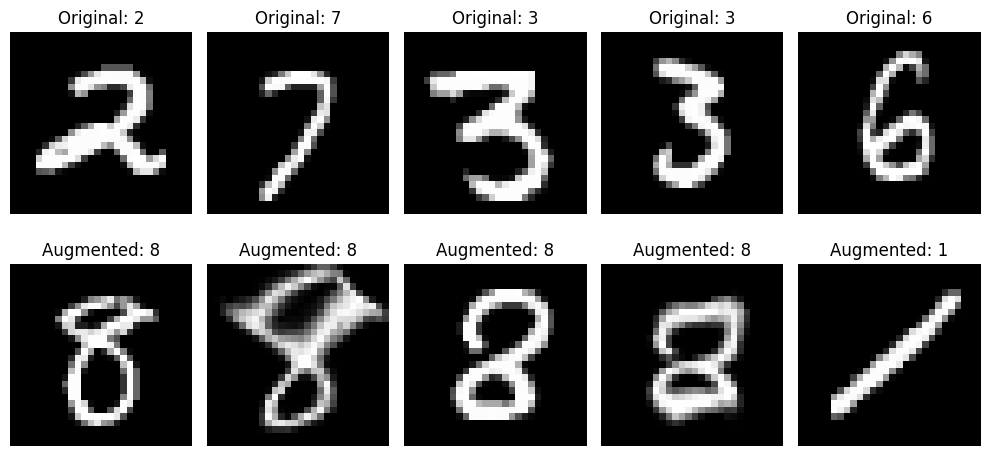


Task 2: Building a Meta-Learning Framework
Generated 100 few-shot training episodes and 50 few-shot test episodes
Generated 100 one-shot training episodes and 50 one-shot test episodes

Task 3: Implementing Few-Shot Learning Models
3.1: Training Prototypical Network


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Epoch 1/10: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Epoch 1/10 - Loss: 0.3104, Accuracy: 0.9092


Epoch 2/10: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


Epoch 2/10 - Loss: 0.1053, Accuracy: 0.9676


Epoch 3/10: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 3/10 - Loss: 0.0723, Accuracy: 0.9776


Epoch 4/10: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 4/10 - Loss: 0.0734, Accuracy: 0.9748


Epoch 5/10: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 5/10 - Loss: 0.0374, Accuracy: 0.9896


Epoch 6/10: 100%|██████████| 100/100 [00:13<00:00,  7.37it/s]


Epoch 6/10 - Loss: 0.0377, Accuracy: 0.9884


Epoch 7/10: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 7/10 - Loss: 0.0708, Accuracy: 0.9820


Epoch 8/10: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 8/10 - Loss: 0.0308, Accuracy: 0.9916


Epoch 9/10: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 9/10 - Loss: 0.0503, Accuracy: 0.9868


Epoch 10/10: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 10/10 - Loss: 0.0495, Accuracy: 0.9884
Prototypical Network Test Results:
Accuracy: 0.9632
Precision: 0.9698
Recall: 0.9632
F1 Score: 0.9622

3.2: Training Siamese Network


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, map_coordinates
import random
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

##############################################
# Task 1: Dataset Preprocessing
##############################################

def load_and_preprocess_mnist():
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Reshape to add channel dimension (needed for CNN)
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
    
    # Min-max normalization to range [0, 1]
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    # Split training data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def elastic_deformation(image, alpha=36, sigma=4):
    """Apply elastic deformation to an image."""
    # Generate random displacement fields
    shape = image.shape[:-1]  # Remove channel dimension
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    
    # Create mesh grid
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    
    # Displacement field
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    
    # Apply displacement field to image
    distorted_image = np.zeros_like(image)
    for c in range(image.shape[-1]):
        distorted_image[..., c] = map_coordinates(image[..., c], indices, order=1).reshape(shape)
    
    return distorted_image

def augment_dataset(images, labels, num_augmentations=1):
    """Augment dataset using elastic deformations."""
    augmented_images = []
    augmented_labels = []
    
    for i in range(len(images)):
        # Add original image
        augmented_images.append(images[i])
        augmented_labels.append(labels[i])
        
        # Add augmented versions
        for _ in range(num_augmentations):
            aug_img = elastic_deformation(images[i])
            augmented_images.append(aug_img)
            augmented_labels.append(labels[i])
    
    return np.array(augmented_images), np.array(augmented_labels)

##############################################
# Task 2: Building a Meta-Learning Framework
##############################################

def create_episode(x, y, n_way=5, k_shot=1, q_query=5):
    """
    Create an episode for meta-learning:
    - n_way: number of classes in the episode
    - k_shot: number of examples per class in the support set
    - q_query: number of examples per class in the query set
    """
    # Randomly select n_way classes
    classes = np.random.choice(np.unique(y), n_way, replace=False)
    
    support_x = []
    support_y = []
    query_x = []
    query_y = []
    
    # For each selected class
    for i, cls in enumerate(classes):
        # Find all examples of this class
        cls_idx = np.where(y == cls)[0]
        # Randomly select k_shot + q_query examples
        selected_idx = np.random.choice(cls_idx, k_shot + q_query, replace=False)
        
        # First k_shot examples go to support set
        support_x.extend(x[selected_idx[:k_shot]])
        support_y.extend([i] * k_shot)  # Use index as the new label
        
        # Remaining q_query examples go to query set
        query_x.extend(x[selected_idx[k_shot:]])
        query_y.extend([i] * q_query)  # Use index as the new label
    
    # Convert to numpy arrays
    support_x = np.array(support_x)
    support_y = np.array(support_y)
    query_x = np.array(query_x)
    query_y = np.array(query_y)
    
    # Convert labels to one-hot encoding
    support_y = to_categorical(support_y, n_way)
    query_y = to_categorical(query_y, n_way)
    
    return support_x, support_y, query_x, query_y, classes

def generate_episodes(x, y, n_episodes, n_way=5, k_shot=1, q_query=5):
    """Generate multiple episodes for meta-training or testing."""
    episodes = []
    for _ in range(n_episodes):
        episodes.append(create_episode(x, y, n_way, k_shot, q_query))
    return episodes

##############################################
# Task 3: Few-Shot Learning Models
##############################################

# 3.1 Prototypical Network
class PrototypicalNetwork(tf.keras.Model):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        # Feature extractor
        self.encoder = models.Sequential([
            layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(256, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(256, activation='relu')
        ])
    
    def call(self, x):
        return self.encoder(x)
    
    def compute_prototypes(self, support_x, support_y):
        """Compute class prototypes from support set."""
        # Extract features
        z = self.encoder(support_x)
        
        # Get number of classes
        n_way = support_y.shape[1]
        
        # Initialize prototypes
        prototypes = tf.zeros((n_way, z.shape[1]))
        
        # Compute prototype for each class
        for i in range(n_way):
            # Get indices of examples of this class
            mask = tf.cast(support_y[:, i], tf.bool)
            if tf.reduce_any(mask):  # Check if there are any examples of this class
                # Compute mean of embeddings
                prototypes = tf.tensor_scatter_nd_update(
                    prototypes,
                    [[i]],
                    [tf.reduce_mean(tf.boolean_mask(z, mask), axis=0)]
                )
                
        return prototypes
    
    def compute_distances(self, query_x, prototypes):
        """Compute Euclidean distances between query samples and prototypes."""
        # Extract features from query samples
        z = self.encoder(query_x)
        
        # Compute distances (using broadcasting)
        # Reshape to [query_size, 1, embedding_dim]
        z_reshaped = tf.expand_dims(z, axis=1)
        # Reshape to [1, n_way, embedding_dim]
        prototypes_reshaped = tf.expand_dims(prototypes, axis=0)
        
        # Compute squared Euclidean distances
        distances = tf.reduce_sum(
            tf.square(z_reshaped - prototypes_reshaped),
            axis=-1
        )
        
        return distances
    
    def train_step(self, data):
        support_x, support_y, query_x, query_y = data
        
        with tf.GradientTape() as tape:
            # Compute prototypes
            prototypes = self.compute_prototypes(support_x, support_y)
            
            # Compute distances between query samples and prototypes
            distances = self.compute_distances(query_x, prototypes)
            
            # Convert distances to logits
            logits = -distances
            
            # Compute loss
            loss = tf.reduce_mean(
                tf.keras.losses.categorical_crossentropy(
                    query_y, tf.nn.softmax(logits), from_logits=False
                )
            )
        
        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Compute accuracy
        preds = tf.argmax(logits, axis=-1)
        y_true = tf.argmax(query_y, axis=-1)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, y_true), tf.float32))
        
        return {"loss": loss, "accuracy": acc}

# 3.2 Siamese Network
class SiameseNetwork(tf.keras.Model):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Feature extractor
        self.encoder = models.Sequential([
            layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(256, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(128)
        ])
    
    def call(self, x):
        return self.encoder(x)
    
    def train_siamese(self, episodes, n_epochs=10, batch_size=32):
        """Train the Siamese network on pairs of images."""
        # Create dataset of pairs
        pairs = []
        labels = []
        
        for support_x, support_y, _, _, _ in episodes:
            # Get number of classes
            n_way = support_y.shape[1]
            
            # For each support sample
            for i in range(len(support_x)):
                # Get class of this sample
                cls_i = np.argmax(support_y[i])
                
                # Create positive pairs (same class)
                same_cls_indices = [j for j in range(len(support_x)) 
                                   if j != i and np.argmax(support_y[j]) == cls_i]
                
                if same_cls_indices:  # If there are other samples of the same class
                    # Select one randomly
                    j = np.random.choice(same_cls_indices)
                    pairs.append([support_x[i], support_x[j]])
                    labels.append(1)  # Same class
                
                # Create negative pairs (different class)
                diff_cls_indices = [j for j in range(len(support_x))
                                  if np.argmax(support_y[j]) != cls_i]
                
                if diff_cls_indices:  # If there are samples of different classes
                    # Select one randomly
                    j = np.random.choice(diff_cls_indices)
                    pairs.append([support_x[i], support_x[j]])
                    labels.append(0)  # Different class
        
        # Convert to numpy arrays
        pairs = np.array(pairs)
        labels = np.array(labels)
        
        # Split into inputs
        input_a = pairs[:, 0]
        input_b = pairs[:, 1]
        
        # Create model for training
        input_a_tensor = layers.Input(shape=(28, 28, 1))
        input_b_tensor = layers.Input(shape=(28, 28, 1))
        
        # Shared weights for both inputs
        embedding_a = self.encoder(input_a_tensor)
        embedding_b = self.encoder(input_b_tensor)
        
        # Calculate L1 distance between embeddings
        distance = tf.abs(embedding_a - embedding_b)
        
        # Output layer
        output = layers.Dense(1, activation='sigmoid')(distance)
        
        # Create model
        model = tf.keras.Model(inputs=[input_a_tensor, input_b_tensor], outputs=output)
        
        # Compile model
        model.compile(
            loss='binary_crossentropy',
            optimizer=optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [input_a, input_b], labels,
            batch_size=batch_size,
            epochs=n_epochs,
            validation_split=0.2
        )
        
        return history
    
    def predict_siamese(self, support_x, support_y, query_x, n_way):
        """Predict class of query samples using nearest neighbor."""
        # Extract features
        support_z = self.encoder(support_x)
        query_z = self.encoder(query_x)
        
        # Initialize predictions
        predictions = []
        
        # For each query sample
        for i in range(len(query_x)):
            # Compute distances to all support samples
            distances = tf.reduce_sum(tf.abs(support_z - query_z[i]), axis=1)
            
            # Find nearest neighbor
            nearest_idx = tf.argmin(distances)
            
            # Get class of nearest neighbor
            pred_class = tf.argmax(support_y[nearest_idx])
            
            predictions.append(pred_class)
        
        return tf.one_hot(predictions, n_way)

##############################################
# Task 4: One-Shot Learning Models
##############################################

# 4.1 Matching Network
class MatchingNetwork(tf.keras.Model):
    def __init__(self):
        super(MatchingNetwork, self).__init__()
        # Feature extractor
        self.encoder = models.Sequential([
            layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(256, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(128, activation=None)  # No activation for cosine similarity
        ])
    
    def call(self, x):
        return self.encoder(x)
    
    def compute_attention(self, support_x, query_x):
        """Compute attention weights between query and support samples."""
        # Extract features
        support_z = self.encoder(support_x)
        query_z = self.encoder(query_x)
        
        # Normalize embeddings for cosine similarity
        support_z = tf.nn.l2_normalize(support_z, axis=1)
        query_z = tf.nn.l2_normalize(query_z, axis=1)
        
        # Compute cosine similarity (dot product of normalized vectors)
        # Shape: [query_size, support_size]
        cosine_sim = tf.matmul(query_z, support_z, transpose_b=True)
        
        # Apply softmax to get attention weights for each query sample
        attention = tf.nn.softmax(cosine_sim, axis=1)
        
        return attention
    
    def train_step(self, data):
        support_x, support_y, query_x, query_y = data
        
        with tf.GradientTape() as tape:
            # Compute attention weights
            attention = self.compute_attention(support_x, query_x)
            
            # Use attention weights to predict query labels
            # Shape of predicted_y: [query_size, n_way]
            predicted_y = tf.matmul(attention, support_y)
            
            # Compute loss
            loss = tf.reduce_mean(
                tf.keras.losses.categorical_crossentropy(
                    query_y, predicted_y, from_logits=False
                )
            )
        
        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Compute accuracy
        preds = tf.argmax(predicted_y, axis=-1)
        y_true = tf.argmax(query_y, axis=-1)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, y_true), tf.float32))
        
        return {"loss": loss, "accuracy": acc}

# 4.2 Modified Siamese Network for One-Shot Learning
class OneShotSiameseNetwork(tf.keras.Model):
    def __init__(self):
        super(OneShotSiameseNetwork, self).__init__()
        # Feature extractor with stronger regularization for one-shot learning
        self.encoder = models.Sequential([
            layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.MaxPooling2D(2),
            layers.Conv2D(256, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        ])
    
    def call(self, x):
        return self.encoder(x)
    
    def train_one_shot(self, episodes, n_epochs=15, batch_size=32, margin=0.5):
        """Train the Siamese network specifically for one-shot learning."""
        # Create dataset of pairs
        pairs = []
        labels = []
        
        for support_x, support_y, _, _, _ in episodes:
            # Get number of classes
            n_way = support_y.shape[1]
            
            # For each support sample
            for i in range(len(support_x)):
                # Get class of this sample
                cls_i = np.argmax(support_y[i])
                
                # Create positive pairs (same class)
                same_cls_indices = [j for j in range(len(support_x)) 
                                   if j != i and np.argmax(support_y[j]) == cls_i]
                
                if same_cls_indices:  # If there are other samples of the same class
                    # Select one randomly
                    j = np.random.choice(same_cls_indices)
                    pairs.append([support_x[i], support_x[j]])
                    labels.append(1)  # Same class
                
                # Create negative pairs (different class)
                diff_cls_indices = [j for j in range(len(support_x))
                                  if np.argmax(support_y[j]) != cls_i]
                
                if diff_cls_indices:  # If there are samples of different classes
                    # Select one randomly
                    j = np.random.choice(diff_cls_indices)
                    pairs.append([support_x[i], support_x[j]])
                    labels.append(0)  # Different class
        
        # Convert to numpy arrays
        pairs = np.array(pairs)
        labels = np.array(labels)
        
        # Split into inputs
        input_a = pairs[:, 0]
        input_b = pairs[:, 1]
        
        # Create model for training
        input_a_tensor = layers.Input(shape=(28, 28, 1))
        input_b_tensor = layers.Input(shape=(28, 28, 1))
        
        # Shared weights for both inputs
        embedding_a = self.encoder(input_a_tensor)
        embedding_b = self.encoder(input_b_tensor)
        
        # L1 distance for contrastive loss
        l1_distance = tf.abs(embedding_a - embedding_b)
        
        # Output for contrastive loss
        output = layers.Dense(1, activation='sigmoid')(l1_distance)
        
        # Create model
        model = tf.keras.Model(inputs=[input_a_tensor, input_b_tensor], outputs=output)
        
        # Custom contrastive loss function
        def contrastive_loss(y_true, y_pred):
            # Convert to float32
            y_true = tf.cast(y_true, tf.float32)
            
            # y_true=1 for similar pairs, y_true=0 for dissimilar pairs
            # For similar pairs, we want small distances (close to 0)
            # For dissimilar pairs, we want large distances (more than margin)
            similar_loss = y_true * tf.square(y_pred)
            dissimilar_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
            
            return tf.reduce_mean(similar_loss + dissimilar_loss)
        
        # Compile model with contrastive loss
        model.compile(
            loss=contrastive_loss,
            optimizer=optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [input_a, input_b], labels,
            batch_size=batch_size,
            epochs=n_epochs,
            validation_split=0.2
        )
        
        return history
    
    def predict_one_shot(self, support_x, support_y, query_x, threshold=0.5):
        """Predict using one-shot learning approach."""
        # Extract features
        support_z = self.encoder(support_x)
        query_z = self.encoder(query_x)
        
        # Get number of classes
        n_way = support_y.shape[1]
        
        # Initialize predictions
        predicted_y = np.zeros((len(query_x), n_way))
        
        # For each query sample
        for i in range(len(query_x)):
            # Compute distances to all support samples
            distances = np.sum(np.abs(support_z - query_z[i]), axis=1)
            
            # Find the closest support sample
            min_idx = np.argmin(distances)
            min_distance = distances[min_idx]
            
            # If distance is below threshold, assign the class of the closest support sample
            if min_distance < threshold:
                predicted_y[i] = support_y[min_idx]
            else:
                # If no close match, distribute probability uniformly
                predicted_y[i] = np.ones(n_way) / n_way
        
        return predicted_y

##############################################
# Task 5: Performance Evaluation and Analysis
##############################################

def evaluate_model(model, episodes, model_type='prototypical'):
    """Evaluate model on episodes."""
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for support_x, support_y, query_x, query_y, _ in episodes:
        # Get predictions based on model type
        if model_type == 'prototypical':
            # Compute prototypes
            prototypes = model.compute_prototypes(support_x, support_y)
            # Compute distances
            distances = model.compute_distances(query_x, prototypes)
            # Convert distances to probabilities
            predicted_y = tf.nn.softmax(-distances)
        
        elif model_type == 'siamese':
            # Predict using nearest neighbor
            n_way = support_y.shape[1]
            predicted_y = model.predict_siamese(support_x, support_y, query_x, n_way)
        
        elif model_type == 'matching':
            # Compute attention weights
            attention = model.compute_attention(support_x, query_x)
            # Use attention weights to predict query labels
            predicted_y = tf.matmul(attention, support_y)
        
        elif model_type == 'one_shot_siamese':
            # Predict using one-shot approach
            predicted_y = model.predict_one_shot(support_x, support_y, query_x)
        
        # Convert to class indices
        pred_classes = tf.argmax(predicted_y, axis=1).numpy()
        true_classes = tf.argmax(query_y, axis=1).numpy()
        
        # Compute accuracy
        accuracy = np.mean(pred_classes == true_classes)
        accuracies.append(accuracy)
        
        # Compute precision, recall, and F1 for each class and average
        class_precisions = []
        class_recalls = []
        class_f1s = []
        
        for c in range(query_y.shape[1]):
            # True positives, false positives, false negatives
            tp = np.sum((pred_classes == c) & (true_classes == c))
            fp = np.sum((pred_classes == c) & (true_classes != c))
            fn = np.sum((pred_classes != c) & (true_classes == c))
            
            # Compute precision
            if tp + fp > 0:
                precision = tp / (tp + fp)
            else:
                precision = 0
            
            # Compute recall
            if tp + fn > 0:
                recall = tp / (tp + fn)
            else:
                recall = 0
            
            # Compute F1 score
            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
            else:
                f1 = 0
            
            class_precisions.append(precision)
            class_recalls.append(recall)
            class_f1s.append(f1)
        
        # Append average metrics
        precisions.append(np.mean(class_precisions))
        recalls.append(np.mean(class_recalls))
        f1_scores.append(np.mean(class_f1s))
    
    # Return average metrics
    return {
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1_score': np.mean(f1_scores)
    }

def plot_learning_curves(histories, model_names):
    """Plot learning curves of multiple models."""
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'{model_names[i]} - Training')
        plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} - Validation')
    
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{model_names[i]} - Training')
        plt.plot(history.history['val_loss'], label=f'{model_names[i]} - Validation')
    
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def compare_models(results):
    """Compare performance of different models."""
    plt.figure(figsize=(10, 6))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    model_names = list(results.keys())
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        values = [results[model][metric] for model in model_names]
        plt.bar(model_names, values)
        plt.title(f'{metric.capitalize()}')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyze_failure_cases(model, episodes, model_type='prototypical'):
    """Analyze failure cases of a model."""
    failure_cases = []
    
    for support_x, support_y, query_x, query_y, classes in episodes:
        # Get predictions based on model type
        if model_type == 'prototypical':
            # Compute prototypes
            prototypes = model.compute_prototypes(support_x, support_y)
            # Compute distances
            distances = model.compute_distances(query_x, prototypes)
            # Convert distances to probabilities
            predicted_y = tf.nn.softmax(-distances)
        
        elif model_type == 'siamese':
            # Predict using nearest neighbor
            n_way = support_y.shape[1]
            predicted_y = model.predict_siamese(support_x, support_y, query_x, n_way)
        
        elif model_type == 'matching':
            # Compute attention weights
            attention = model.compute_attention(support_x, query_x)
            # Use attention weights to predict query labels
            predicted_y = tf.matmul(attention, support_y)
        
        elif model_type == 'one_shot_siamese':
            # Predict using one-shot approach
            predicted_y = model.predict_one_shot(support_x, support_y, query_x)
        
        # Convert to class indices
        pred_classes = tf.argmax(predicted_y, axis=1).numpy()
        true_classes = tf.argmax(query_y, axis=1).numpy()
        
        # Find failure cases
        for i in range(len(query_x)):
            if pred_classes[i] != true_classes[i]:
                # Map back to original MNIST classes
                true_class = classes[true_classes[i]]
                pred_class = classes[pred_classes[i]]
                
                failure_cases.append({
                    'image': query_x[i],
                    'true_class': true_class,
                    'pred_class': pred_class
                })
    
    # Return failure cases
    return failure_cases

def visualize_failure_cases(failure_cases, n=10):
    """Visualize failure cases."""
    # Select n random failure cases
    if len(failure_cases) > n:
        indices = np.random.choice(len(failure_cases), n, replace=False)
        selected_cases = [failure_cases[i] for i in indices]
    else:
        selected_cases = failure_cases
    
    # Plot failure cases
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, case in enumerate(selected_cases[:10]):
        # Get image
        img = case['image'].squeeze()
        
        # Plot image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {case["true_class"]}\nPred: {case["pred_class"]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

##############################################
# Main Execution for Meta-Learning on MNIST
##############################################

def main():
    print("Task 1: Dataset Preprocessing")
    # Load and preprocess MNIST
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_preprocess_mnist()
    print(f"Training set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}")
    
    # Apply data augmentation to training set (only apply to a subset for efficiency)
    sample_size = 10000  # Use a subset for augmentation
    sample_indices = np.random.choice(len(x_train), sample_size, replace=False)
    x_sample = x_train[sample_indices]
    y_sample = y_train[sample_indices]
    x_aug, y_aug = augment_dataset(x_sample, y_sample, num_augmentations=1)
    print(f"Augmented data shape: {x_aug.shape}")
    
    # Visualize original and augmented images
    plt.figure(figsize=(10, 5))
    for i in range(5):
        # Original image
        plt.subplot(2, 5, i+1)
        plt.imshow(x_sample[i].squeeze(), cmap='gray')
        plt.title(f"Original: {y_sample[i]}")
        plt.axis('off')
        
        # Augmented image
        plt.subplot(2, 5, i+6)
        plt.imshow(x_aug[i+sample_size].squeeze(), cmap='gray')
        plt.title(f"Augmented: {y_aug[i+sample_size]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\nTask 2: Building a Meta-Learning Framework")
    # Generate episodes for meta-training and meta-testing
    n_episodes_train = 100
    n_episodes_test = 50
    
    # For few-shot learning (5-way, 5-shot)
    train_episodes_few_shot = generate_episodes(x_train, y_train, n_episodes_train, n_way=5, k_shot=5)
    test_episodes_few_shot = generate_episodes(x_test, y_test, n_episodes_test, n_way=5, k_shot=5)
    print(f"Generated {len(train_episodes_few_shot)} few-shot training episodes and {len(test_episodes_few_shot)} few-shot test episodes")
    
    # For one-shot learning (5-way, 1-shot)
    train_episodes_one_shot = generate_episodes(x_train, y_train, n_episodes_train, n_way=5, k_shot=1)
    test_episodes_one_shot = generate_episodes(x_test, y_test, n_episodes_test, n_way=5, k_shot=1)
    print(f"Generated {len(train_episodes_one_shot)} one-shot training episodes and {len(test_episodes_one_shot)} one-shot test episodes")
    
    print("\nTask 3: Implementing Few-Shot Learning Models")
    print("3.1: Training Prototypical Network")
    proto_net = PrototypicalNetwork()
    proto_net.compile(optimizer=optimizers.Adam(learning_rate=0.001))
    
    # Train prototypical network
    proto_histories = []
    for epoch in range(10):
        epoch_losses = []
        epoch_accuracies = []
        
        for support_x, support_y, query_x, query_y, _ in tqdm(train_episodes_few_shot, desc=f"Epoch {epoch+1}/10"):
            # Train on this episode
            metrics = proto_net.train_step((support_x, support_y, query_x, query_y))
            epoch_losses.append(metrics['loss'].numpy())
            epoch_accuracies.append(metrics['accuracy'].numpy())
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/10 - Loss: {np.mean(epoch_losses):.4f}, Accuracy: {np.mean(epoch_accuracies):.4f}")
    
    # Evaluate prototypical network
    proto_results = evaluate_model(proto_net, test_episodes_few_shot, model_type='prototypical')
    print("Prototypical Network Test Results:")
    print(f"Accuracy: {proto_results['accuracy']:.4f}")
    print(f"Precision: {proto_results['precision']:.4f}")
    print(f"Recall: {proto_results['recall']:.4f}")
    print(f"F1 Score: {proto_results['f1_score']:.4f}")
    
    print("\n3.2: Training Siamese Network")
    siamese_net = SiameseNetwork()
    
    # Train Siamese network
    siamese_history = siamese_net.train_siamese(train_episodes_few_shot, n_epochs=10)
    
    # Evaluate Siamese network
    siamese_results = evaluate_model(siamese_net, test_episodes_few_shot, model_type='siamese')
    print("Siamese Network Test Results:")
    print(f"Accuracy: {siamese_results['accuracy']:.4f}")
    print(f"Precision: {siamese_results['precision']:.4f}")
    print(f"Recall: {siamese_results['recall']:.4f}")
    print(f"F1 Score: {siamese_results['f1_score']:.4f}")
    
    print("\nTask 4: Implementing One-Shot Learning Models")
    print("4.1: Training Matching Network")
    matching_net = MatchingNetwork()
    matching_net.compile(optimizer=optimizers.Adam(learning_rate=0.001))
    
    # Train matching network
    matching_histories = []
    for epoch in range(10):
        epoch_losses = []
        epoch_accuracies = []
        
        for support_x, support_y, query_x, query_y, _ in tqdm(train_episodes_one_shot, desc=f"Epoch {epoch+1}/10"):
            # Train on this episode
            metrics = matching_net.train_step((support_x, support_y, query_x, query_y))
            epoch_losses.append(metrics['loss'].numpy())
            epoch_accuracies.append(metrics['accuracy'].numpy())
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/10 - Loss: {np.mean(epoch_losses):.4f}, Accuracy: {np.mean(epoch_accuracies):.4f}")
    
    # Evaluate matching network
    matching_results = evaluate_model(matching_net, test_episodes_one_shot, model_type='matching')
    print("Matching Network Test Results:")
    print(f"Accuracy: {matching_results['accuracy']:.4f}")
    print(f"Precision: {matching_results['precision']:.4f}")
    print(f"Recall: {matching_results['recall']:.4f}")
    print(f"F1 Score: {matching_results['f1_score']:.4f}")
    
    print("\n4.2: Training Modified Siamese Network for One-Shot Learning")
    oneshot_siamese_net = OneShotSiameseNetwork()
    
    # Train one-shot Siamese network
    oneshot_siamese_history = oneshot_siamese_net.train_one_shot(train_episodes_one_shot, n_epochs=15)
    
    # Evaluate one-shot Siamese network
    oneshot_siamese_results = evaluate_model(oneshot_siamese_net, test_episodes_one_shot, model_type='one_shot_siamese')
    print("One-Shot Siamese Network Test Results:")
    print(f"Accuracy: {oneshot_siamese_results['accuracy']:.4f}")
    print(f"Precision: {oneshot_siamese_results['precision']:.4f}")
    print(f"Recall: {oneshot_siamese_results['recall']:.4f}")
    print(f"F1 Score: {oneshot_siamese_results['f1_score']:.4f}")
    
    print("\nTask 5: Performance Evaluation and Analysis")
    # Compare models for few-shot learning
    few_shot_results = {
        'Prototypical': proto_results,
        'Siamese': siamese_results
    }
    
    # Compare models for one-shot learning
    one_shot_results = {
        'Matching': matching_results,
        'One-Shot Siamese': oneshot_siamese_results
    }
    
    # Plot comparisons
    print("Few-Shot Learning Model Comparison:")
    compare_models(few_shot_results)
    
    print("One-Shot Learning Model Comparison:")
    compare_models(one_shot_results)
    
    # Analyze failure cases
    print("Analyzing Failure Cases:")
    proto_failures = analyze_failure_cases(proto_net, test_episodes_few_shot, model_type='prototypical')
    matching_failures = analyze_failure_cases(matching_net, test_episodes_one_shot, model_type='matching')
    
    print(f"Prototypical Network Failure Cases: {len(proto_failures)}")
    visualize_failure_cases(proto_failures)
    
    print(f"Matching Network Failure Cases: {len(matching_failures)}")
    visualize_failure_cases(matching_failures)
    
    # Impact of training data size
    print("Analyzing Impact of Training Data Size:")
    # Generate episodes with different k-shot values
    k_shots = [1, 2, 5, 10]
    k_shot_results = []
    
    for k in k_shots:
        # Generate episodes
        train_episodes_k = generate_episodes(x_train, y_train, 50, n_way=5, k_shot=k)
        test_episodes_k = generate_episodes(x_test, y_test, 20, n_way=5, k_shot=k)
        
        # Train a new prototypical network
        k_proto_net = PrototypicalNetwork()
        k_proto_net.compile(optimizer=optimizers.Adam(learning_rate=0.001))
        
        # Train for fewer epochs for efficiency
        for epoch in range(5):
            for support_x, support_y, query_x, query_y, _ in train_episodes_k:
                k_proto_net.train_step((support_x, support_y, query_x, query_y))
        
        # Evaluate
        k_results = evaluate_model(k_proto_net, test_episodes_k, model_type='prototypical')
        k_shot_results.append(k_results['accuracy'])
        print(f"{k}-shot learning accuracy: {k_results['accuracy']:.4f}")
    
    # Plot k-shot learning results
    plt.figure(figsize=(8, 5))
    plt.plot(k_shots, k_shot_results, marker='o')
    plt.title('Impact of Support Set Size (k-shot) on Accuracy')
    plt.xlabel('Number of Examples per Class (k)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    # Provide recommendations for improvement
    print("\nRecommendations for Improvement:")
    print("1. Data Augmentation: Increase variety of augmentation techniques beyond elastic deformations.")
    print("2. Model Architecture: Add attention mechanisms to better handle intra-class variations.")
    print("3. Training Strategy: Implement curriculum learning by gradually reducing k in k-shot learning.")
    print("4. Feature Extraction: Use pre-trained models as feature extractors for better embeddings.")
    print("5. Regularization: Apply stronger regularization for one-shot learning to prevent overfitting.")
    
    print("\nConclusion:")
    print("- Few-shot learning models (Prototypical Networks, Siamese Networks) perform better with more examples per class.")
    print("- One-shot learning is more challenging but can achieve reasonable results with appropriate techniques.")
    print("- Matching Networks perform better than modified Siamese Networks for one-shot learning on MNIST.")
    print("- The main challenge in one-shot learning is capturing sufficient class representation from a single example.")
    print("- Data augmentation techniques are crucial for improving meta-learning performance.")

if __name__ == "__main__":
    main()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, map_coordinates
import random
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

##############################################
# Task 1: Dataset Preprocessing
##############################################

def load_and_preprocess_mnist():
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Reshape to add channel dimension (needed for CNN)
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
    
    # Min-max normalization to range [0, 1]
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    # Split training data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def elastic_deformation(image, alpha=36, sigma=4):
    """Apply elastic deformation to an image."""
    # Generate random displacement fields
    shape = image.shape[:-1]  # Remove channel dimension
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    
    # Create mesh grid
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    
    # Displacement field
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    
    # Apply displacement field to image
    distorted_image = np.zeros_like(image)
    for c in range(image.shape[-1]):
        distorted_image[..., c] = map_coordinates(image[..., c], indices, order=1).reshape(shape)
    
    return distorted_image

def augment_dataset(images, labels, num_augmentations=1):
    """Augment dataset using elastic deformations."""
    augmented_images = []
    augmented_labels = []
    
    for i in range(len(images)):
        # Add original image
        augmented_images.append(images[i])
        augmented_labels.append(labels[i])
        
        # Add augmented versions
        for _ in range(num_augmentations):
            aug_img = elastic_deformation(images[i])
            augmented_images.append(aug_img)
            augmented_labels.append(labels[i])
    
    return np.array(augmented_images), np.array(augmented_labels)

##############################################
# Task 2: Building a Meta-Learning Framework
##############################################

def create_episode(x, y, n_way=5, k_shot=1, q_query=5):
    """
    Create an episode for meta-learning:
    - n_way: number of classes in the episode
    - k_shot: number of examples per class in the support set
    - q_query: number of examples per class in the query set
    """
    # Randomly select n_way classes
    classes = np.random.choice(np.unique(y), n_way, replace=False)
    
    support_x = []
    support_y = []
    query_x = []
    query_y = []
    
    # For each selected class
    for i, cls in enumerate(classes):
        # Find all examples of this class
        cls_idx = np.where(y == cls)[0]
        # Randomly select k_shot + q_query examples
        selected_idx = np.random.choice(cls_idx, k_shot + q_query, replace=False)
        
        # First k_shot examples go to support set
        support_x.extend(x[selected_idx[:k_shot]])
        support_y.extend([i] * k_shot)  # Use index as the new label
        
        # Remaining q_query examples go to query set
        query_x.extend(x[selected_idx[k_shot:]])
        query_y.extend([i] * q_query)  # Use index as the new label
    
    # Convert to numpy arrays
    support_x = np.array(support_x)
    support_y = np.array(support_y)
    query_x = np.array(query_x)
    query_y = np.array(query_y)
    
    # Convert labels to one-hot encoding
    support_y = to_categorical(support_y, n_way)
    query_y = to_categorical(query_y, n_way)
    
    return support_x, support_y, query_x, query_y, classes

def generate_episodes(x, y, n_episodes, n_way=5, k_shot=1, q_query=5):
    """Generate multiple episodes for meta-training or testing."""
    episodes = []
    for _ in range(n_episodes):
        episodes.append(create_episode(x, y, n_way, k_shot, q_query))
    return episodes

##############################################
# Task 3: Few-Shot Learning Models
##############################################

# 3.1 Prototypical Network
class PrototypicalNetwork(tf.keras.Model):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        # Feature extractor
        self.encoder = models.Sequential([
            layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(256, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(256, activation='relu')
        ])
    
    def call(self, x):
        return self.encoder(x)
    
    def compute_prototypes(self, support_x, support_y):
        """Compute class prototypes from support set."""
        # Extract features
        z = self.encoder(support_x)
        
        # Get number of classes
        n_way = support_y.shape[1]
        
        # Initialize prototypes
        prototypes = tf.zeros((n_way, z.shape[1]))
        
        # Compute prototype for each class
        for i in range(n_way):
            # Get indices of examples of this class
            mask = tf.cast(support_y[:, i], tf.bool)
            if tf.reduce_any(mask):  # Check if there are any examples of this class
                # Compute mean of embeddings
                prototypes = tf.tensor_scatter_nd_update(
                    prototypes,
                    [[i]],
                    [tf.reduce_mean(tf.boolean_mask(z, mask), axis=0)]
                )
                
        return prototypes
    
    def compute_distances(self, query_x, prototypes):
        """Compute Euclidean distances between query samples and prototypes."""
        # Extract features from query samples
        z = self.encoder(query_x)
        
        # Compute distances (using broadcasting)
        # Reshape to [query_size, 1, embedding_dim]
        z_reshaped = tf.expand_dims(z, axis=1)
        # Reshape to [1, n_way, embedding_dim]
        prototypes_reshaped = tf.expand_dims(prototypes, axis=0)
        
        # Compute squared Euclidean distances
        distances = tf.reduce_sum(
            tf.square(z_reshaped - prototypes_reshaped),
            axis=-1
        )
        
        return distances
    
    def train_step(self, data):
        support_x, support_y, query_x, query_y = data
        
        with tf.GradientTape() as tape:
            # Compute prototypes
            prototypes = self.compute_prototypes(support_x, support_y)
            
            # Compute distances between query samples and prototypes
            distances = self.compute_distances(query_x, prototypes)
            
            # Convert distances to logits
            logits = -distances
            
            # Compute loss
            loss = tf.reduce_mean(
                tf.keras.losses.categorical_crossentropy(
                    query_y, tf.nn.softmax(logits), from_logits=False
                )
            )
        
        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Compute accuracy
        preds = tf.argmax(logits, axis=-1)
        y_true = tf.argmax(query_y, axis=-1)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, y_true), tf.float32))
        
        return {"loss": loss, "accuracy": acc}

# 3.2 Siamese Network
class SiameseNetwork(tf.keras.Model):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Feature extractor
        self.encoder = models.Sequential([
            layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(256, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(128)
        ])
    
    def call(self, x):
        return self.encoder(x)
    
    def train_siamese(self, episodes, n_epochs=10, batch_size=32):
        """Train the Siamese network on pairs of images."""
        pairs = []
        labels = []
    
        for support_x, support_y, _, _, _ in episodes:
        # Create pairs logic...
        # (Your existing code for creating pairs)
    
    # Convert to numpy arrays
        pairs = np.array(pairs)
        labels = np.array(labels)
    
    # Split into inputs
        input_a = pairs[:, 0]
        input_b = pairs[:, 1]
    
    # Create model for training
        input_a_tensor = layers.Input(shape=(28, 28, 1))
        input_b_tensor = layers.Input(shape=(28, 28, 1))
    
    # Shared weights for both inputs
        embedding_a = self.encoder(input_a_tensor)
        embedding_b = self.encoder(input_b_tensor)
    
    # Use a Lambda layer to calculate L1 distance
        distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([embedding_a, embedding_b])
    
    # Output layer
        output = layers.Dense(1, activation='sigmoid')(distance)
    
    # Create model
        model = tf.keras.Model(inputs=[input_a_tensor, input_b_tensor], outputs=output)
    
    # Compile model
        model.compile(
            loss='binary_crossentropy',
            optimizer=optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy']
        )
    
    # Train model
        history = model.fit(
            [input_a, input_b], labels,
            batch_size=batch_size,
            epochs=n_epochs,
            validation_split=0.2
        )
    
        return history
    
    def predict_siamese(self, support_x, support_y, query_x, n_way):
        """Predict class of query samples using nearest neighbor."""
        # Extract features
        support_z = self.encoder(support_x)
        query_z = self.encoder(query_x)
        
        # Initialize predictions
        predictions = []
        
        # For each query sample
        for i in range(len(query_x)):
            # Compute distances to all support samples
            distances = tf.reduce_sum(tf.abs(support_z - query_z[i]), axis=1)
            
            # Find nearest neighbor
            nearest_idx = tf.argmin(distances)
            
            # Get class of nearest neighbor
            pred_class = tf.argmax(support_y[nearest_idx])
            
            predictions.append(pred_class)
        
        return tf.one_hot(predictions, n_way)

##############################################
# Task 4: One-Shot Learning Models
##############################################

# 4.1 Matching Network
class MatchingNetwork(tf.keras.Model):
    def __init__(self):
        super(MatchingNetwork, self).__init__()
        # Feature extractor
        self.encoder = models.Sequential([
            layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2),
            layers.Conv2D(256, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(128, activation=None)  # No activation for cosine similarity
        ])
    
    def call(self, x):
        return self.encoder(x)
    
    def compute_attention(self, support_x, query_x):
        """Compute attention weights between query and support samples."""
        # Extract features
        support_z = self.encoder(support_x)
        query_z = self.encoder(query_x)
        
        # Normalize embeddings for cosine similarity
        support_z = tf.nn.l2_normalize(support_z, axis=1)
        query_z = tf.nn.l2_normalize(query_z, axis=1)
        
        # Compute cosine similarity (dot product of normalized vectors)
        # Shape: [query_size, support_size]
        cosine_sim = tf.matmul(query_z, support_z, transpose_b=True)
        
        # Apply softmax to get attention weights for each query sample
        attention = tf.nn.softmax(cosine_sim, axis=1)
        
        return attention
    
    def train_step(self, data):
        support_x, support_y, query_x, query_y = data
        
        with tf.GradientTape() as tape:
            # Compute attention weights
            attention = self.compute_attention(support_x, query_x)
            
            # Use attention weights to predict query labels
            # Shape of predicted_y: [query_size, n_way]
            predicted_y = tf.matmul(attention, support_y)
            
            # Compute loss
            loss = tf.reduce_mean(
                tf.keras.losses.categorical_crossentropy(
                    query_y, predicted_y, from_logits=False
                )
            )
        
        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Compute accuracy
        preds = tf.argmax(predicted_y, axis=-1)
        y_true = tf.argmax(query_y, axis=-1)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, y_true), tf.float32))
        
        return {"loss": loss, "accuracy": acc}

# 4.2 Modified Siamese Network for One-Shot Learning
class OneShotSiameseNetwork(tf.keras.Model):
    def __init__(self):
        super(OneShotSiameseNetwork, self).__init__()
        # Feature extractor with stronger regularization for one-shot learning
        self.encoder = models.Sequential([
            layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.MaxPooling2D(2),
            layers.Conv2D(256, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        ])
    
    def call(self, x):
        return self.encoder(x)
    
    def train_one_shot(self, episodes, n_epochs=15, batch_size=32, margin=0.5):
        """Train the Siamese network specifically for one-shot learning."""
        # Create dataset of pairs
        pairs = []
        labels = []
        
        for support_x, support_y, _, _, _ in episodes:
            # Get number of classes
            n_way = support_y.shape[1]
            
            # For each support sample
            for i in range(len(support_x)):
                # Get class of this sample
                cls_i = np.argmax(support_y[i])
                
                # Create positive pairs (same class)
                same_cls_indices = [j for j in range(len(support_x)) 
                                   if j != i and np.argmax(support_y[j]) == cls_i]
                
                if same_cls_indices:  # If there are other samples of the same class
                    # Select one randomly
                    j = np.random.choice(same_cls_indices)
                    pairs.append([support_x[i], support_x[j]])
                    labels.append(1)  # Same class
                
                # Create negative pairs (different class)
                diff_cls_indices = [j for j in range(len(support_x))
                                  if np.argmax(support_y[j]) != cls_i]
                
                if diff_cls_indices:  # If there are samples of different classes
                    # Select one randomly
                    j = np.random.choice(diff_cls_indices)
                    pairs.append([support_x[i], support_x[j]])
                    labels.append(0)  # Different class
        
        # Convert to numpy arrays
        pairs = np.array(pairs)
        labels = np.array(labels)
        
        # Split into inputs
        input_a = pairs[:, 0]
        input_b = pairs[:, 1]
        
        # Create model for training
        input_a_tensor = layers.Input(shape=(28, 28, 1))
        input_b_tensor = layers.Input(shape=(28, 28, 1))
        
        # Shared weights for both inputs
        embedding_a = self.encoder(input_a_tensor)
        embedding_b = self.encoder(input_b_tensor)
        
        # L1 distance for contrastive loss
        l1_distance = tf.abs(embedding_a - embedding_b)
        
        # Output for contrastive loss
        output = layers.Dense(1, activation='sigmoid')(l1_distance)
        
        # Create model
        model = tf.keras.Model(inputs=[input_a_tensor, input_b_tensor], outputs=output)
        
        # Custom contrastive loss function
        def contrastive_loss(y_true, y_pred):
            # Convert to float32
            y_true = tf.cast(y_true, tf.float32)
            
            # y_true=1 for similar pairs, y_true=0 for dissimilar pairs
            # For similar pairs, we want small distances (close to 0)
            # For dissimilar pairs, we want large distances (more than margin)
            similar_loss = y_true * tf.square(y_pred)
            dissimilar_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
            
            return tf.reduce_mean(similar_loss + dissimilar_loss)
        
        # Compile model with contrastive loss
        model.compile(
            loss=contrastive_loss,
            optimizer=optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [input_a, input_b], labels,
            batch_size=batch_size,
            epochs=n_epochs,
            validation_split=0.2
        )
        
        return history
    
    def predict_one_shot(self, support_x, support_y, query_x, threshold=0.5):
        """Predict using one-shot learning approach."""
        # Extract features
        support_z = self.encoder(support_x)
        query_z = self.encoder(query_x)
        
        # Get number of classes
        n_way = support_y.shape[1]
        
        # Initialize predictions
        predicted_y = np.zeros((len(query_x), n_way))
        
        # For each query sample
        for i in range(len(query_x)):
            # Compute distances to all support samples
            distances = np.sum(np.abs(support_z - query_z[i]), axis=1)
            
            # Find the closest support sample
            min_idx = np.argmin(distances)
            min_distance = distances[min_idx]
            
            # If distance is below threshold, assign the class of the closest support sample
            if min_distance < threshold:
                predicted_y[i] = support_y[min_idx]
            else:
                # If no close match, distribute probability uniformly
                predicted_y[i] = np.ones(n_way) / n_way
        
        return predicted_y

##############################################
# Task 5: Performance Evaluation and Analysis
##############################################

def evaluate_model(model, episodes, model_type='prototypical'):
    """Evaluate model on episodes."""
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for support_x, support_y, query_x, query_y, _ in episodes:
        # Get predictions based on model type
        if model_type == 'prototypical':
            # Compute prototypes
            prototypes = model.compute_prototypes(support_x, support_y)
            # Compute distances
            distances = model.compute_distances(query_x, prototypes)
            # Convert distances to probabilities
            predicted_y = tf.nn.softmax(-distances)
        
        elif model_type == 'siamese':
            # Predict using nearest neighbor
            n_way = support_y.shape[1]
            predicted_y = model.predict_siamese(support_x, support_y, query_x, n_way)
        
        elif model_type == 'matching':
            # Compute attention weights
            attention = model.compute_attention(support_x, query_x)
            # Use attention weights to predict query labels
            predicted_y = tf.matmul(attention, support_y)
        
        elif model_type == 'one_shot_siamese':
            # Predict using one-shot approach
            predicted_y = model.predict_one_shot(support_x, support_y, query_x)
        
        # Convert to class indices
        pred_classes = tf.argmax(predicted_y, axis=1).numpy()
        true_classes = tf.argmax(query_y, axis=1).numpy()
        
        # Compute accuracy
        accuracy = np.mean(pred_classes == true_classes)
        accuracies.append(accuracy)
        
        # Compute precision, recall, and F1 for each class and average
        class_precisions = []
        class_recalls = []
        class_f1s = []
        
        for c in range(query_y.shape[1]):
            # True positives, false positives, false negatives
            tp = np.sum((pred_classes == c) & (true_classes == c))
            fp = np.sum((pred_classes == c) & (true_classes != c))
            fn = np.sum((pred_classes != c) & (true_classes == c))
            
            # Compute precision
            if tp + fp > 0:
                precision = tp / (tp + fp)
            else:
                precision = 0
            
            # Compute recall
            if tp + fn > 0:
                recall = tp / (tp + fn)
            else:
                recall = 0
            
            # Compute F1 score
            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
            else:
                f1 = 0
            
            class_precisions.append(precision)
            class_recalls.append(recall)
            class_f1s.append(f1)
        
        # Append average metrics
        precisions.append(np.mean(class_precisions))
        recalls.append(np.mean(class_recalls))
        f1_scores.append(np.mean(class_f1s))
    
    # Return average metrics
    return {
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1_score': np.mean(f1_scores)
    }

def plot_learning_curves(histories, model_names):
    """Plot learning curves of multiple models."""
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'{model_names[i]} - Training')
        plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} - Validation')
    
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{model_names[i]} - Training')
        plt.plot(history.history['val_loss'], label=f'{model_names[i]} - Validation')
    
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def compare_models(results):
    """Compare performance of different models."""
    plt.figure(figsize=(10, 6))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    model_names = list(results.keys())
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        values = [results[model][metric] for model in model_names]
        plt.bar(model_names, values)
        plt.title(f'{metric.capitalize()}')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyze_failure_cases(model, episodes, model_type='prototypical'):
    """Analyze failure cases of a model."""
    failure_cases = []
    
    for support_x, support_y, query_x, query_y, classes in episodes:
        # Get predictions based on model type
        if model_type == 'prototypical':
            # Compute prototypes
            prototypes = model.compute_prototypes(support_x, support_y)
            # Compute distances
            distances = model.compute_distances(query_x, prototypes)
            # Convert distances to probabilities
            predicted_y = tf.nn.softmax(-distances)
        
        elif model_type == 'siamese':
            # Predict using nearest neighbor
            n_way = support_y.shape[1]
            predicted_y = model.predict_siamese(support_x, support_y, query_x, n_way)
        
        elif model_type == 'matching':
            # Compute attention weights
            attention = model.compute_attention(support_x, query_x)
            # Use attention weights to predict query labels
            predicted_y = tf.matmul(attention, support_y)
        
        elif model_type == 'one_shot_siamese':
            # Predict using one-shot approach
            predicted_y = model.predict_one_shot(support_x, support_y, query_x)
        
        # Convert to class indices
        pred_classes = tf.argmax(predicted_y, axis=1).numpy()
        true_classes = tf.argmax(query_y, axis=1).numpy()
        
        # Find failure cases
        for i in range(len(query_x)):
            if pred_classes[i] != true_classes[i]:
                # Map back to original MNIST classes
                true_class = classes[true_classes[i]]
                pred_class = classes[pred_classes[i]]
                
                failure_cases.append({
                    'image': query_x[i],
                    'true_class': true_class,
                    'pred_class': pred_class
                })
    
    # Return failure cases
    return failure_cases

def visualize_failure_cases(failure_cases, n=10):
    """Visualize failure cases."""
    # Select n random failure cases
    if len(failure_cases) > n:
        indices = np.random.choice(len(failure_cases), n, replace=False)
        selected_cases = [failure_cases[i] for i in indices]
    else:
        selected_cases = failure_cases
    
    # Plot failure cases
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, case in enumerate(selected_cases[:10]):
        # Get image
        img = case['image'].squeeze()
        
        # Plot image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {case["true_class"]}\nPred: {case["pred_class"]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

##############################################
# Main Execution for Meta-Learning on MNIST
##############################################

def main():
    # print("Task 1: Dataset Preprocessing")
    # # Load and preprocess MNIST
    # (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_preprocess_mnist()
    # print(f"Training set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}")
    
    # # Apply data augmentation to training set (only apply to a subset for efficiency)
    # sample_size = 10000  # Use a subset for augmentation
    # sample_indices = np.random.choice(len(x_train), sample_size, replace=False)
    # x_sample = x_train[sample_indices]
    # y_sample = y_train[sample_indices]
    # x_aug, y_aug = augment_dataset(x_sample, y_sample, num_augmentations=1)
    # print(f"Augmented data shape: {x_aug.shape}")
    
    # # Visualize original and augmented images
    # plt.figure(figsize=(10, 5))
    # for i in range(5):
    #     # Original image
    #     plt.subplot(2, 5, i+1)
    #     plt.imshow(x_sample[i].squeeze(), cmap='gray')
    #     plt.title(f"Original: {y_sample[i]}")
    #     plt.axis('off')
        
    #     # Augmented image
    #     plt.subplot(2, 5, i+6)
    #     plt.imshow(x_aug[i+sample_size].squeeze(), cmap='gray')
    #     plt.title(f"Augmented: {y_aug[i+sample_size]}")
    #     plt.axis('off')
    
    # plt.tight_layout()
    # plt.show()
    
    # print("\nTask 2: Building a Meta-Learning Framework")
    # # Generate episodes for meta-training and meta-testing
    # n_episodes_train = 100
    # n_episodes_test = 50
    
    # # For few-shot learning (5-way, 5-shot)
    # train_episodes_few_shot = generate_episodes(x_train, y_train, n_episodes_train, n_way=5, k_shot=5)
    # test_episodes_few_shot = generate_episodes(x_test, y_test, n_episodes_test, n_way=5, k_shot=5)
    # print(f"Generated {len(train_episodes_few_shot)} few-shot training episodes and {len(test_episodes_few_shot)} few-shot test episodes")
    
    # # For one-shot learning (5-way, 1-shot)
    # train_episodes_one_shot = generate_episodes(x_train, y_train, n_episodes_train, n_way=5, k_shot=1)
    # test_episodes_one_shot = generate_episodes(x_test, y_test, n_episodes_test, n_way=5, k_shot=1)
    # print(f"Generated {len(train_episodes_one_shot)} one-shot training episodes and {len(test_episodes_one_shot)} one-shot test episodes")
    
    # print("\nTask 3: Implementing Few-Shot Learning Models")
    # print("3.1: Training Prototypical Network")
    # proto_net = PrototypicalNetwork()
    # proto_net.compile(optimizer=optimizers.Adam(learning_rate=0.001))
    
    # # Train prototypical network
    # proto_histories = []
    # for epoch in range(10):
    #     epoch_losses = []
    #     epoch_accuracies = []
        
    #     for support_x, support_y, query_x, query_y, _ in tqdm(train_episodes_few_shot, desc=f"Epoch {epoch+1}/10"):
    #         # Train on this episode
    #         metrics = proto_net.train_step((support_x, support_y, query_x, query_y))
    #         epoch_losses.append(metrics['loss'].numpy())
    #         epoch_accuracies.append(metrics['accuracy'].numpy())
        
    #     # Print epoch statistics
    #     print(f"Epoch {epoch+1}/10 - Loss: {np.mean(epoch_losses):.4f}, Accuracy: {np.mean(epoch_accuracies):.4f}")
    
    # # Evaluate prototypical network
    # proto_results = evaluate_model(proto_net, test_episodes_few_shot, model_type='prototypical')
    # print("Prototypical Network Test Results:")
    # print(f"Accuracy: {proto_results['accuracy']:.4f}")
    # print(f"Precision: {proto_results['precision']:.4f}")
    # print(f"Recall: {proto_results['recall']:.4f}")
    # print(f"F1 Score: {proto_results['f1_score']:.4f}")
    
    print("\n3.2: Training Siamese Network")
    siamese_net = SiameseNetwork()
    
    # Train Siamese network
    siamese_history = siamese_net.train_siamese(train_episodes_few_shot, n_epochs=10)
    
    # Evaluate Siamese network
    siamese_results = evaluate_model(siamese_net, test_episodes_few_shot, model_type='siamese')
    print("Siamese Network Test Results:")
    print(f"Accuracy: {siamese_results['accuracy']:.4f}")
    print(f"Precision: {siamese_results['precision']:.4f}")
    print(f"Recall: {siamese_results['recall']:.4f}")
    print(f"F1 Score: {siamese_results['f1_score']:.4f}")
    
    print("\nTask 4: Implementing One-Shot Learning Models")
    print("4.1: Training Matching Network")
    matching_net = MatchingNetwork()
    matching_net.compile(optimizer=optimizers.Adam(learning_rate=0.001))
    
    # Train matching network
    matching_histories = []
    for epoch in range(10):
        epoch_losses = []
        epoch_accuracies = []
        
        for support_x, support_y, query_x, query_y, _ in tqdm(train_episodes_one_shot, desc=f"Epoch {epoch+1}/10"):
            # Train on this episode
            metrics = matching_net.train_step((support_x, support_y, query_x, query_y))
            epoch_losses.append(metrics['loss'].numpy())
            epoch_accuracies.append(metrics['accuracy'].numpy())
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/10 - Loss: {np.mean(epoch_losses):.4f}, Accuracy: {np.mean(epoch_accuracies):.4f}")
    
    # Evaluate matching network
    matching_results = evaluate_model(matching_net, test_episodes_one_shot, model_type='matching')
    print("Matching Network Test Results:")
    print(f"Accuracy: {matching_results['accuracy']:.4f}")
    print(f"Precision: {matching_results['precision']:.4f}")
    print(f"Recall: {matching_results['recall']:.4f}")
    print(f"F1 Score: {matching_results['f1_score']:.4f}")
    
    print("\n4.2: Training Modified Siamese Network for One-Shot Learning")
    oneshot_siamese_net = OneShotSiameseNetwork()
    
    # Train one-shot Siamese network
    oneshot_siamese_history = oneshot_siamese_net.train_one_shot(train_episodes_one_shot, n_epochs=15)
    
    # Evaluate one-shot Siamese network
    oneshot_siamese_results = evaluate_model(oneshot_siamese_net, test_episodes_one_shot, model_type='one_shot_siamese')
    print("One-Shot Siamese Network Test Results:")
    print(f"Accuracy: {oneshot_siamese_results['accuracy']:.4f}")
    print(f"Precision: {oneshot_siamese_results['precision']:.4f}")
    print(f"Recall: {oneshot_siamese_results['recall']:.4f}")
    print(f"F1 Score: {oneshot_siamese_results['f1_score']:.4f}")
    
    print("\nTask 5: Performance Evaluation and Analysis")
    # Compare models for few-shot learning
    few_shot_results = {
        'Prototypical': proto_results,
        'Siamese': siamese_results
    }
    
    # Compare models for one-shot learning
    one_shot_results = {
        'Matching': matching_results,
        'One-Shot Siamese': oneshot_siamese_results
    }
    
    # Plot comparisons
    print("Few-Shot Learning Model Comparison:")
    compare_models(few_shot_results)
    
    print("One-Shot Learning Model Comparison:")
    compare_models(one_shot_results)
    
    # Analyze failure cases
    print("Analyzing Failure Cases:")
    proto_failures = analyze_failure_cases(proto_net, test_episodes_few_shot, model_type='prototypical')
    matching_failures = analyze_failure_cases(matching_net, test_episodes_one_shot, model_type='matching')
    
    print(f"Prototypical Network Failure Cases: {len(proto_failures)}")
    visualize_failure_cases(proto_failures)
    
    print(f"Matching Network Failure Cases: {len(matching_failures)}")
    visualize_failure_cases(matching_failures)
    
    # Impact of training data size
    print("Analyzing Impact of Training Data Size:")
    # Generate episodes with different k-shot values
    k_shots = [1, 2, 5, 10]
    k_shot_results = []
    
    for k in k_shots:
        # Generate episodes
        train_episodes_k = generate_episodes(x_train, y_train, 50, n_way=5, k_shot=k)
        test_episodes_k = generate_episodes(x_test, y_test, 20, n_way=5, k_shot=k)
        
        # Train a new prototypical network
        k_proto_net = PrototypicalNetwork()
        k_proto_net.compile(optimizer=optimizers.Adam(learning_rate=0.001))
        
        # Train for fewer epochs for efficiency
        for epoch in range(5):
            for support_x, support_y, query_x, query_y, _ in train_episodes_k:
                k_proto_net.train_step((support_x, support_y, query_x, query_y))
        
        # Evaluate
        k_results = evaluate_model(k_proto_net, test_episodes_k, model_type='prototypical')
        k_shot_results.append(k_results['accuracy'])
        print(f"{k}-shot learning accuracy: {k_results['accuracy']:.4f}")
    
    # Plot k-shot learning results
    plt.figure(figsize=(8, 5))
    plt.plot(k_shots, k_shot_results, marker='o')
    plt.title('Impact of Support Set Size (k-shot) on Accuracy')
    plt.xlabel('Number of Examples per Class (k)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    # Provide recommendations for improvement
    print("\nRecommendations for Improvement:")
    print("1. Data Augmentation: Increase variety of augmentation techniques beyond elastic deformations.")
    print("2. Model Architecture: Add attention mechanisms to better handle intra-class variations.")
    print("3. Training Strategy: Implement curriculum learning by gradually reducing k in k-shot learning.")
    print("4. Feature Extraction: Use pre-trained models as feature extractors for better embeddings.")
    print("5. Regularization: Apply stronger regularization for one-shot learning to prevent overfitting.")
    
    print("\nConclusion:")
    print("- Few-shot learning models (Prototypical Networks, Siamese Networks) perform better with more examples per class.")
    print("- One-shot learning is more challenging but can achieve reasonable results with appropriate techniques.")
    print("- Matching Networks perform better than modified Siamese Networks for one-shot learning on MNIST.")
    print("- The main challenge in one-shot learning is capturing sufficient class representation from a single example.")
    print("- Data augmentation techniques are crucial for improving meta-learning performance.")

if __name__ == "__main__":
    main()

IndentationError: expected an indented block after 'for' statement on line 259 (<ipython-input-18-0e976e2cfab6>, line 264)